# Analysis of Animal Shelter Data in Sonoma County, CA

## Goal of Analysis

Our main goal is to shed insight on the outcomes of animals surrendered to Sonoma County Animal Services.

## About the Data

We retrieved the data from SoCo Data, which is an open data portal for the County of Sonoma. Here is a link to the data: https://data.sonomacounty.ca.gov/Government/Animal-Shelter-Intake-and-Outcome/924a-vesw

In [1]:
!pip install catboost

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sheltertools.utils import *
import random
random.seed(159)


In [3]:
shelter_data = pd.read_csv('./data/Animal_Shelter_Data.csv')
shelter_data.shape

(25008, 24)

In [4]:
shelter_data.head()

,Name,Type,Breed,Color,Sex,Size,Date Of Birth,Impound Number,Kennel Number,Animal ID,...,Intake Subtype,Outcome Type,Outcome Subtype,Intake Condition,Outcome Condition,Intake Jurisdiction,Outcome Jurisdiction,Outcome Zip Code,Location,Count
0,RAZOR,DOG,BOSTON TERRIER,BLACK/WHITE,Neutered,SMALL,10/29/2009,K22-043412,TRUCK,A396382,...,FIELD,RETURN TO OWNER,FLD_IDTAG,UNKNOWN,HEALTHY,SANTA ROSA,SANTA ROSA,95404.0,"95404(38.43807, -122.71247)",1
1,NaN,OTHER,PIGEON,GRAY/WHITE,Unknown,SMALL,NaN,K23-044095,TRUCK,A416206,...,FIELD,EUTHANIZE,INJ SEVERE,UNKNOWN,HEALTHY,SANTA ROSA,NaN,NaN,NaN,1
2,MAX,DOG,BORDER COLLIE,BLACK/TRICOLOR,Neutered,MED,03/10/2020,K23-044090,DS80,A399488,...,FIELD,RETURN TO OWNER,OVER THE COUNTER_CALL,UNKNOWN,PENDING,COUNTY,COUNTY,95472.0,"95472(38.40179, -122.82512)",1
3,NaN,CAT,DOMESTIC LH,GRAY/WHITE,Spayed,SMALL,06/26/2011,K22-043405,VET,A414520,...,FIELD,DISPOSAL,DOA,UNKNOWN,DEAD,COUNTY,SANTA ROSA,95403.0,"95403(38.51311, -122.75502)",1
4,PUDGY,DOG,CHIHUAHUA SH/SCHIPPERKE,TAN,Neutered,MED,07/20/2013,K23-043813,DA27,A415428,...,OVER THE COUNTER,TRANSFER,MUTTVILLE,UNKNOWN,HEALTHY,SANTA ROSA,OUT OF COUNTY,94103.0,"94103(37.77672, -122.40779)",1


In [5]:
shelter_data.columns

Index(['Name', 'Type', 'Breed', 'Color', 'Sex', 'Size', 'Date Of Birth',
       'Impound Number', 'Kennel Number', 'Animal ID', 'Intake Date',
       'Outcome Date', 'Days in Shelter', 'Intake Type', 'Intake Subtype',
       'Outcome Type', 'Outcome Subtype', 'Intake Condition',
       'Outcome Condition', 'Intake Jurisdiction', 'Outcome Jurisdiction',
       'Outcome Zip Code', 'Location', 'Count'],
      dtype='object')

### Data Cleaning

In [6]:
shelter_data.dropna(subset=['Size'], inplace=True)
shelter_data.isnull().sum()

Name                    6567
Type                       0
Breed                      0
Color                      0
Sex                        0
Size                       0
Date Of Birth           6206
Impound Number             0
Kennel Number             12
Animal ID                  0
Intake Date                0
Outcome Date             159
Days in Shelter            0
Intake Type                0
Intake Subtype             0
Outcome Type             165
Outcome Subtype          482
Intake Condition           0
Outcome Condition        508
Intake Jurisdiction        0
Outcome Jurisdiction    3508
Outcome Zip Code        3565
Location                3565
Count                      0
dtype: int64

## Data Assumptions?

## Methods

### EDA

#### Explore the Number of Animals in the Shelter by Type

In [7]:
number_of_animals_by_type(shelter_data)
#shelter_data.groupby('Intake_Type')['Type'].value_counts()

Intake Type      Type 
ADOPTION RETURN  DOG        292
                 CAT        116
                 OTHER        4
BORN HERE        CAT         16
                 OTHER        1
CONFISCATE       DOG       1456
                 CAT        245
                 OTHER      197
OS APPT          DOG          1
OWNER SURRENDER  CAT       1595
                 DOG       1414
                 OTHER      143
QUARANTINE       DOG        424
                 OTHER      277
                 CAT        118
STRAY            DOG      10223
                 CAT       6603
                 OTHER     1417
TRANSFER         DOG        258
                 CAT        161
                 OTHER       12
Name: Type, dtype: int64

#### EDA: What are the Top Cat Breeds in the Shelter?

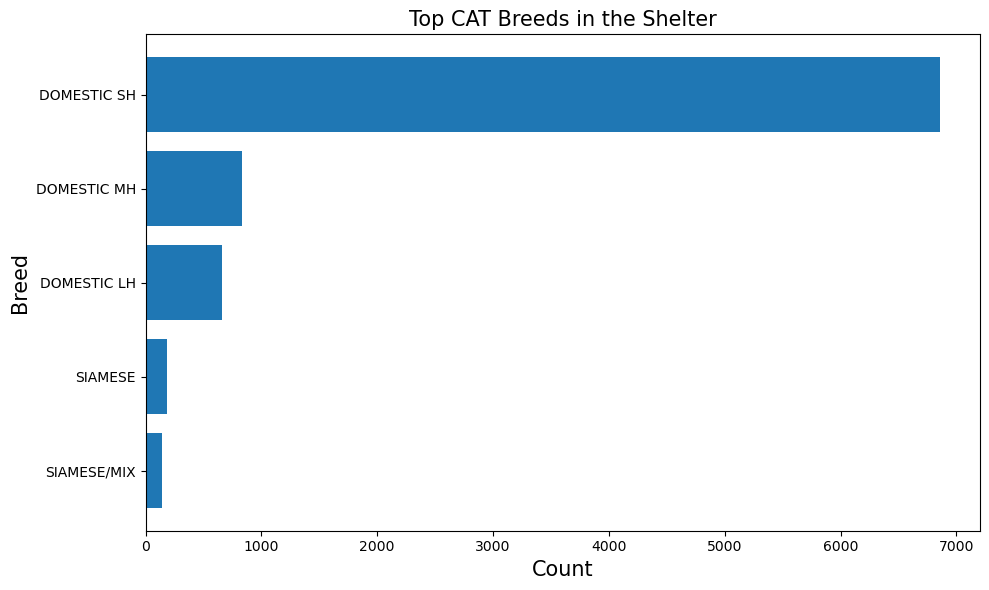

In [8]:
plot_top_breeds('CAT', shelter_data)
# cat_data = shelter_data[shelter_data['Type'] == 'CAT']
# cat_breed_counts = cat_data['Breed'].value_counts(ascending=True).tail(5)
# plt.barh(cat_breed_counts.index, cat_breed_counts)
# plt.title('Top Cat Breeds in the Shelter', size=15)
# plt.xlabel('Count', size=15)
# plt.ylabel('Breed', size=15)
# plt.show()

#### EDA: What are the Top Dog Breeds in the Shelter?

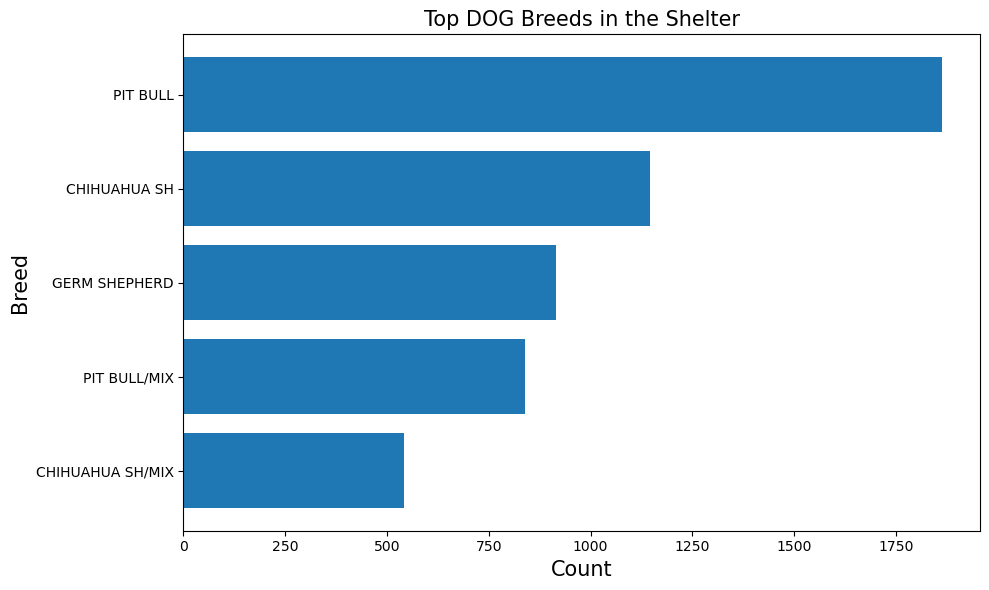

In [9]:
plot_top_breeds('DOG', shelter_data)
# dog_data = shelter_data[shelter_data['Type'] == 'DOG']
# dog_breed_counts = dog_data['Breed'].value_counts(ascending=True).tail(5)
# plt.barh(dog_breed_counts.index, dog_breed_counts)
# plt.title('Top Dog Breeds in the Shelter', size=15)
# plt.xlabel('Count', size=15)
# plt.ylabel('Breed', size=15)
# plt.show()

#### EDA: What are the most common names for different species in the shelter?

In [10]:
top_names = shelter_data.groupby(["Type","Name"], as_index=False).size()
top_names = top_names.sort_values(by='size', ascending=False).groupby(["Type"]).head(3)
top_names

,Type,Name,size
4614,DOG,BUDDY,131
6004,DOG,LUNA,115
4402,DOG,BELLA,104
2291,CAT,MILO,21
2197,CAT,LUCY,19
758,CAT,*LUKE,17
7727,OTHER,*JESSICA,9
7864,OTHER,*ROGER,7
8036,OTHER,OREO,5


From the table above, we can see that the top three most common names for dogs at the adoption centers are Buddy, Luna, and Bella. On the other hand, the top three most common names for adopted cats are Milo, Lucy, and Smokey.

#### Trend line: which year has the most number of animal intakes?

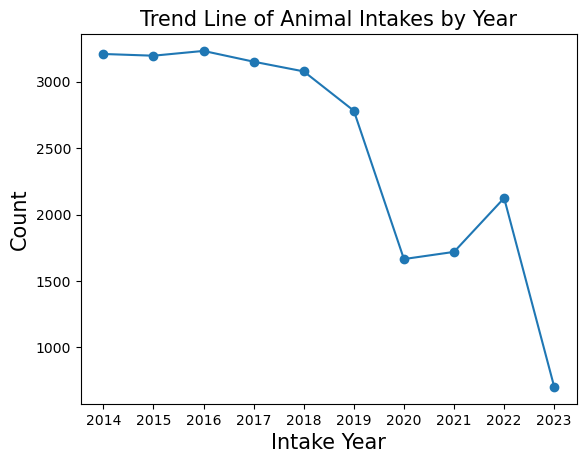

In [11]:
shelter_data['Intake Year'] = shelter_data['Intake Date'].apply(lambda x: x[-4:])

# Filter the data to only include records from the year 2014 and later.
shelter_data = shelter_data[shelter_data['Intake Year'] != '2013']
intake_counts = shelter_data.groupby('Intake Year').size()
intake_counts.plot(kind='line', title='Animal Intakes by Year')
plt.scatter(x=intake_counts.index, y=intake_counts)
plt.xticks(np.arange(len(intake_counts)), intake_counts.index)
plt.xlabel('Intake Year', size=15)
plt.ylabel('Count', size=15)
plt.title('Trend Line of Animal Intakes by Year', size=15)
plt.show()

#### EDA: Outcomes By Species

In [12]:
# Select species and outcome type
outcome_data = shelter_data.loc[:,["Type", "Outcome Type"]]
outcome_data

,Type,Outcome Type
0,DOG,RETURN TO OWNER
1,OTHER,EUTHANIZE
2,DOG,RETURN TO OWNER
3,CAT,DISPOSAL
4,DOG,TRANSFER
...,...,...
25003,CAT,ADOPTION
25004,OTHER,TRANSFER
25005,DOG,EUTHANIZE
25006,DOG,TRANSFER


In [13]:
# Drop NA
outcome_data.dropna(subset=['Outcome Type'], inplace=True)
outcome_data.isnull().sum()

Type            0
Outcome Type    0
dtype: int64

In [14]:
# Calculate the proportion of species within each outcome type
top_outcome = outcome_data.groupby([ "Type","Outcome Type"],as_index=False).size()
top_outcome = top_outcome.groupby([ "Type","Outcome Type"], group_keys=False).agg({"size":"sum"}).groupby(
    level=0,group_keys=False).apply(lambda x: 100*x/x.sum()).sort_values(
    by=["Type","size", "Outcome Type"], ascending=[False, False, True])
top_outcome =top_outcome.rename(columns={"size":"percent"})
top_outcome

percent
Type  Outcome Type              
OTHER TRANSFER         42.814668
      EUTHANIZE        21.902874
      ADOPTION         21.110010
      RETURN TO OWNER   9.910803
      DIED              2.279485
      DISPOSAL          1.734390
      ESCAPED/STOLEN    0.247770
DOG   RETURN TO OWNER  50.504468
      ADOPTION         23.400115
      TRANSFER         14.600749
      EUTHANIZE        10.723551
      RTOS              0.266647
      DISPOSAL          0.252234
      DIED              0.216201
      ESCAPED/STOLEN    0.036033
CAT   ADOPTION         40.857403
      TRANSFER         26.620423
      EUTHANIZE        16.272458
      RETURN TO OWNER  13.236297
      DISPOSAL          1.785308
      DIED              1.023425
      RTOS              0.125085
      ESCAPED/STOLEN    0.079600

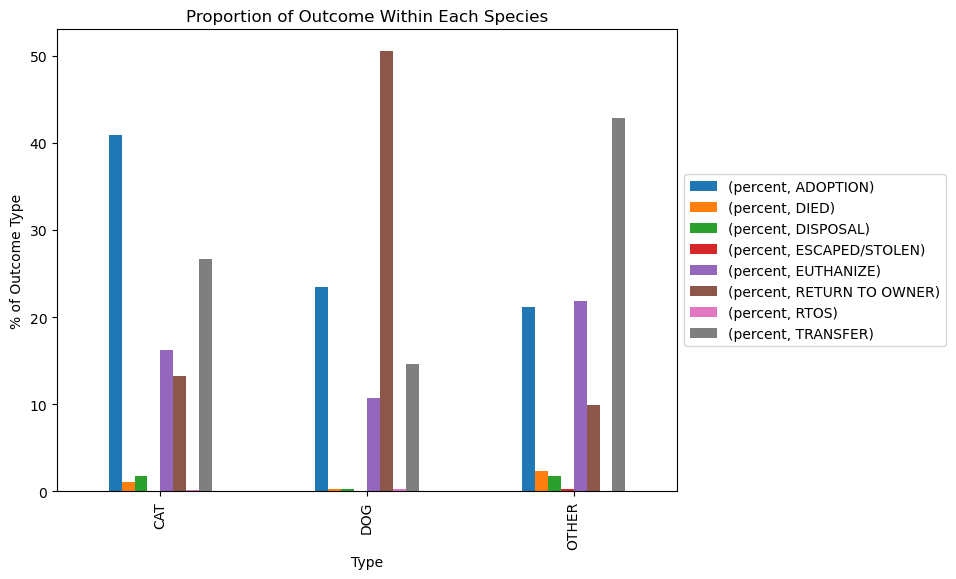

In [15]:
# Create bar plot to visualize most common outcome type within each species
ax = top_outcome.pivot_table(index="Type", columns="Outcome Type").plot(kind='bar')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.set_ylabel("% of Outcome Type")
ax.set_title("Proportion of Outcome Within Each Species");
fig = ax.get_figure()
fig.set_size_inches(8, 6) 
fig.savefig('figures/' + 'Proportion_of_Outcome_Within_Each_Species', bbox_inches='tight')

Adoption was the most common outcome for cats at 41%. Half of the dogs in the shelter are being returned to owner, whereas most of the other species (43%) are being transferred. 

#### Performance of Shelter based on Adoption rate, Transfer rate, Return-to-owner rate, and Euthanasia Rate

In [16]:
# Display the overall rates for each species and outcome type throughout all years
rates_df = top_outcome.pivot_table(index="Type", columns="Outcome Type")
rates_df

percent                                                \
Outcome Type   ADOPTION      DIED  DISPOSAL ESCAPED/STOLEN  EUTHANIZE   
Type                                                                    
CAT           40.857403  1.023425  1.785308       0.079600  16.272458   
DOG           23.400115  0.216201  0.252234       0.036033  10.723551   
OTHER         21.110010  2.279485  1.734390       0.247770  21.902874   

                                                   
Outcome Type RETURN TO OWNER      RTOS   TRANSFER  
Type                                               
CAT                13.236297  0.125085  26.620423  
DOG                50.504468  0.266647  14.600749  
OTHER               9.910803       NaN  42.814668

In [17]:
# Add year column to the dataframe using Outcome Date
outcome_data2 = shelter_data.loc[:,["Outcome Date","Outcome Type"]]
outcome_data2["Outcome Date"] = pd.to_datetime(outcome_data2['Outcome Date'])
outcome_data2["year"] = pd.DatetimeIndex(outcome_data2['Outcome Date']).year
outcome_data2

,Outcome Date,Outcome Type,year
0,2022-12-26,RETURN TO OWNER,2022.0
1,2023-03-15,EUTHANIZE,2023.0
2,2023-03-15,RETURN TO OWNER,2023.0
3,2022-12-27,DISPOSAL,2022.0
4,2023-03-15,TRANSFER,2023.0
...,...,...,...
25003,2019-10-23,ADOPTION,2019.0
25004,2018-10-10,TRANSFER,2018.0
25005,2014-10-02,EUTHANIZE,2014.0
25006,2020-08-20,TRANSFER,2020.0


In [18]:
# Calculate the proportion of outcome type in each year
yearly_rate = outcome_data2.groupby([ "year","Outcome Type"],as_index=False).size()
yearly_rate = yearly_rate.groupby(["year","Outcome Type"], group_keys=False).agg({"size":"sum"}).groupby(
    level=0,group_keys=False).apply(lambda x: 100*x/x.sum()).sort_values(
    by=["year","size", "Outcome Type"], ascending=[True, False, True]).reset_index()
yearly_rate =yearly_rate.rename(columns={"size":"percent"})
yearly_rate

,year,Outcome Type,percent
0,2014.0,ADOPTION,36.818033
1,2014.0,RETURN TO OWNER,34.465861
2,2014.0,TRANSFER,14.211042
3,2014.0,EUTHANIZE,12.969618
4,2014.0,DIED,0.947403
...,...,...,...
66,2023.0,EUTHANIZE,13.112392
67,2023.0,DIED,1.008646
68,2023.0,DISPOSAL,1.008646
69,2023.0,RTOS,0.576369


In [19]:
# Function to plot trend line for rates given Outcome Type
# def trend_proportion(Outcome):
#     outcome_type = yearly_rate[yearly_rate["Outcome Type"]==Outcome]
#     ax = outcome_type.plot(x="year",y="percent")
#     ax.set_ylabel("% out of total intakes")
#     ax.set_title("Proportion of "+Outcome+" by year")
    

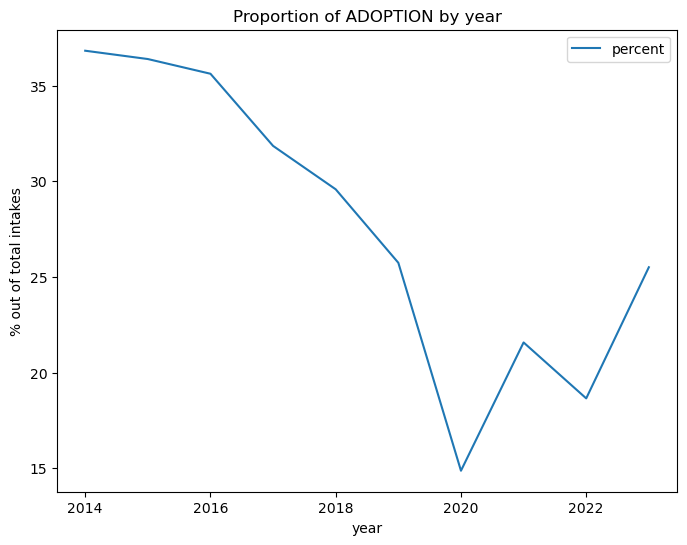

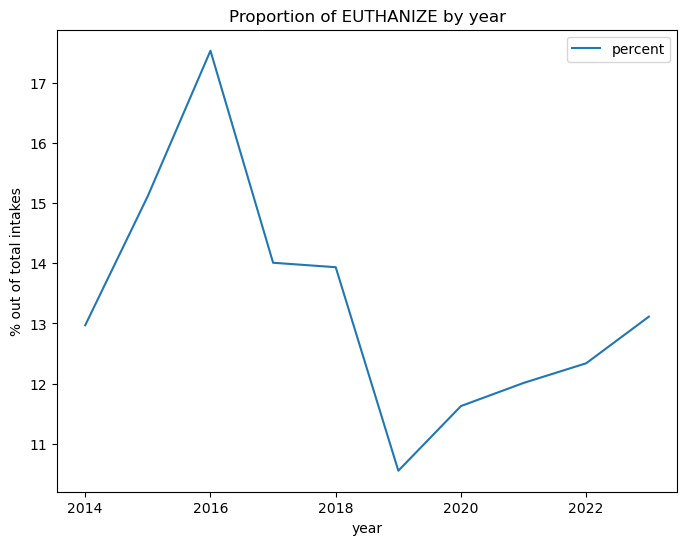

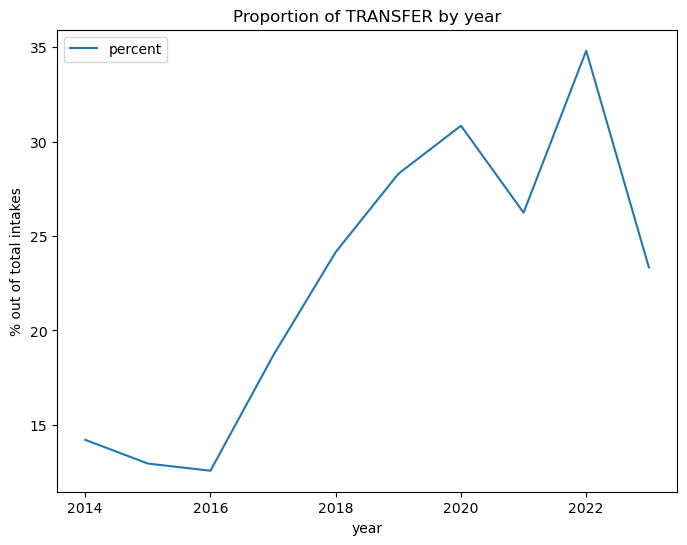

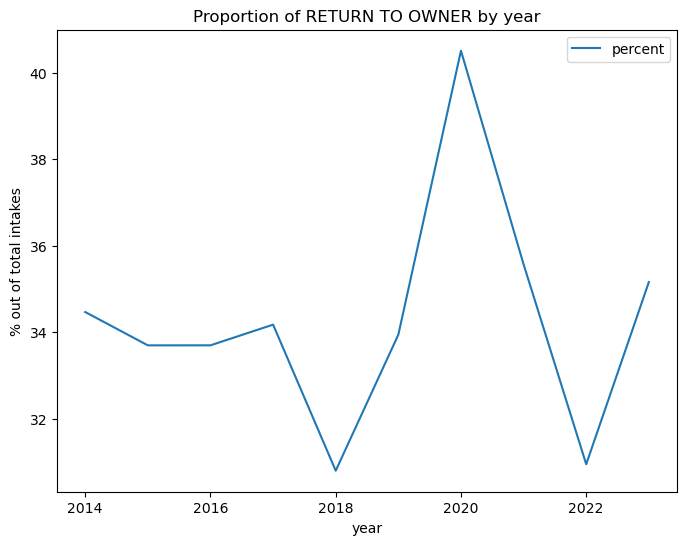

In [20]:
# Visualize rates
adoption = trend_proportion("ADOPTION", yearly_rate)
euthanize = trend_proportion("EUTHANIZE", yearly_rate)
transferred = trend_proportion("TRANSFER", yearly_rate)
rto = trend_proportion("RETURN TO OWNER", yearly_rate)

It appears that as the adoption rate declines throughout the years, the shelter chooses to transfer than animals rather than euthanizing. 

### Modeling

#### Predict whether an Animal is adopted eventually

In [21]:
shelter_data.rename(columns={'Intake Subtype': 'Intake_Subtype',
                            'Intake Type': 'Intake_Type',
                            'Intake Condition': 'Intake_Condition'}, inplace=True)

In [22]:
# Create a new column named Adopted, and assign a value of 0 or 1 
# to indicate whether each animal has been adopted or not.
shelter_data['Adopted'] = (shelter_data['Outcome Type'] == 'ADOPTION').astype(int)

#Split the data into test and train
shelter_train, shelter_test = train_test_split(shelter_data, test_size=0.3, random_state=159)
shelter_train.shape, shelter_test.shape

((17397, 26), (7456, 26))

In [23]:
import statsmodels.formula.api as smf
logreg = smf.logit(formula = 'Adopted ~ Type + Sex + Size + Intake_Type + Intake_Condition',
                       data = shelter_train).fit()
print(logreg.summary())

         Current function value: 0.351088
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:                Adopted   No. Observations:                17397
Model:                          Logit   Df Residuals:                    17373
Method:                           MLE   Df Model:                           23
Date:                Mon, 08 May 2023   Pseudo R-squ.:                  0.4198
Time:                        21:20:04   Log-Likelihood:                -6107.9
converged:                      False   LL-Null:                       -10527.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
Intercept                                   -0.1241      0.211     -0.589      0.556

/srv/conda/envs/notebook/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [24]:
# Predicting the probability of adopted
y_prob = logreg.predict(shelter_test)

# Predicting the label: 0 or 1?
y_pred = pd.Series([1 if x > 1/2 else 0 for x in y_prob], index=y_prob.index)

from sklearn.metrics import confusion_matrix
y_test = shelter_test['Adopted']
cm = confusion_matrix(y_test, y_pred)
print ("Confusion Matrix : \n", cm) 

Confusion Matrix : 
 [[4851  442]
 [ 842 1321]]


In [25]:
TN, FP, FN, TP = cm.ravel()

# What is the Accuracy?
acc= (TN + TP) / sum(cm.ravel())
print('Accuracy is: %.4f' %acc)


# What is the True Positive Rate ?
TPR_logit = TP/(TP+FN)
print('TPR is: %.4f' % TPR_logit)

# What is the False Positive rate ?
FPR_logit = FP/(FP+TN)
print('FPR is: %.4f' % FPR_logit)

Accuracy is: 0.8278
TPR is: 0.6107
FPR is: 0.0835


### Predicting Days Before Adoption

In [26]:
### filtering on animals that are ultimately adopted
adopted_all = shelter_data[shelter_data['Outcome Type'] == 'ADOPTION']

### keeping only relevant columns
adopted = adopted_all[['Type', 'Breed', 'Color', 'Sex', 'Size', 'Date Of Birth', 'Intake Date','Days in Shelter', 
                       'Intake_Type', 'Intake_Subtype', 'Intake_Condition', 'Intake Jurisdiction', 'Location',
                      'Intake Year']]
adopted = adopted.reset_index(drop=True)

### creating a feature for animal age at intake time
adopted = adopted[~adopted['Date Of Birth'].isna()]
adopted = adopted.reset_index(drop=True)
adopted['age'] = (pd.to_datetime(adopted['Intake Date'], format='%m/%d/%Y') - pd.to_datetime(adopted['Date Of Birth'], 
                                                                                            format='%m/%d/%Y')).dt.days
adopted = adopted.drop(columns=['Intake Date', 'Date Of Birth'])
adopted = adopted.fillna('nan')

In [27]:
adopted_all.columns

Index(['Name', 'Type', 'Breed', 'Color', 'Sex', 'Size', 'Date Of Birth',
       'Impound Number', 'Kennel Number', 'Animal ID', 'Intake Date',
       'Outcome Date', 'Days in Shelter', 'Intake_Type', 'Intake_Subtype',
       'Outcome Type', 'Outcome Subtype', 'Intake_Condition',
       'Outcome Condition', 'Intake Jurisdiction', 'Outcome Jurisdiction',
       'Outcome Zip Code', 'Location', 'Count', 'Intake Year', 'Adopted'],
      dtype='object')

In [28]:
adopted['log_days'] = np.log1p(adopted['Days in Shelter'])

In [29]:
adopted_filtered = adopted[adopted['Days in Shelter']< 200]

In [30]:
### test train split
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(adopted_filtered.drop(['Days in Shelter', 'log_days'], axis=1), 
                                                    adopted_filtered['log_days'], test_size=0.2, random_state=42)

In [31]:
model = CatBoostRegressor(cat_features=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], loss_function='MAE', verbose=500,
                         depth=9, iterations=1500, learning_rate=0.05)
model.fit(X_train, y_train)
predictions = model.predict(X_test)

0:	learn: 0.6449894	total: 68.8ms	remaining: 1m 43s
500:	learn: 0.3096699	total: 11.3s	remaining: 22.5s
1000:	learn: 0.2512172	total: 23.6s	remaining: 11.7s
1499:	learn: 0.2182771	total: 35.3s	remaining: 0us


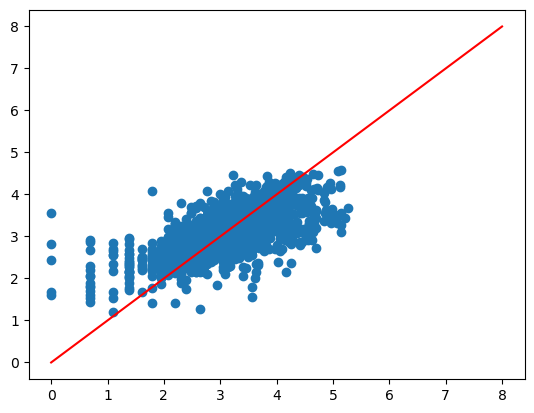

In [32]:
x = np.linspace(0, 8, 100)
y = x

plt.plot(x, y, color='red');
plt.scatter(x=y_test, y=predictions);
plt.show()

In [33]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

unlog_pred = np.expm1(predictions)
unlog_actual = np.expm1(y_test)

rmse = mean_squared_error(unlog_actual, unlog_pred, squared=False)
r2 = r2_score(unlog_actual, unlog_pred)

print("Testing performance")
print('RMSE: {:.2f}'.format(rmse))
print('R2: {:.2f}'.format(r2))

Testing performance
RMSE: 22.66
R2: 0.32


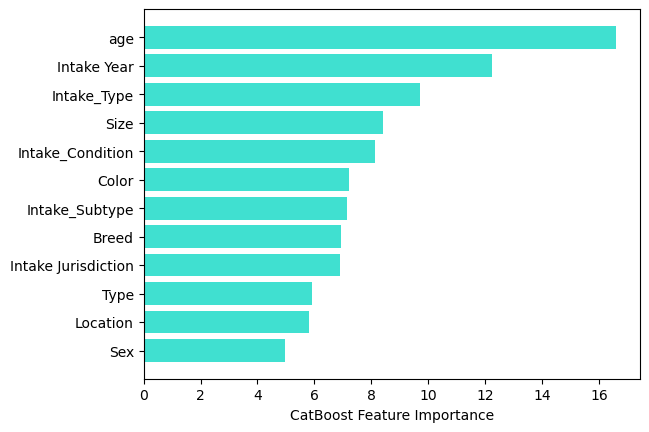

In [34]:
sorted_feature_importance = model.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_feature_importance], 
        model.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance");

## Results

## Conclusions

## Author Contributions